# Coagulation Basics 2: PDF Representation

### Continuous Particle Size Distributions

In this notebook, we implement the coagulation process for continuous particle size distributions, following the methodology outlined in Seinfeld and Pandis (2006). This work builds on concepts from `Coagulation Basics 1: PMF Representation` by extending the analysis to probability density function (PDF) representations of particle size distributions.

#### Objective

The primary objective is to demonstrate the calculation of the coagulation kernel and the resulting coagulation rates for a given particle size distribution. We will compare the PDF representation with the probability mass function (PMF) representation, highlighting how the PDF's continuous nature influences the coagulation process.

#### Approach

1. **Uniform Distribution**:
   - We begin with a uniform particle size distribution to illustrate the fundamental mechanics of coagulation.
  
2. **Lognormal Probability Density Function**:
   - After establishing the basics with a uniform distribution, we proceed to a lognormal size distribution, which more accurately reflects real-world aerosol size distributions. The PDF representation is continuous and describes the probability of finding particles within a specific size range. Integrating the PDF across the entire size range yields the total particle concentration.
  
   - **Units**:
     - The units of the PDF are particles per unit volume per unit size, typically expressed as $\dfrac{1}{m^3 \cdot m}$ or $\dfrac{1}{m^4}$. Integration of the PDF over the particle size range gives the total number concentration, expressed in $\dfrac{1}{m^3}$.

This step-by-step approach lays the groundwork for more advanced implementations, such as those in the `particula` library.

---

#### Required Libraries

We will use common scientific libraries, including `numpy` for numerical calculations, `matplotlib` for visualization, and `pandas` for data manipulation. Additionally, we will leverage specific functions from the `particula` library to compute the coagulation kernel and generate size distributions.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapezoid

# particula imports
from particula.next.dynamics.coagulation import brownian_kernel, rate
from particula.next.particles.properties.lognormal_size_distribution import (
    lognormal_pdf_distribution,
)
from particula.util.convert import distribution_convert_pdf_pms

# The `brownian_kernel` function calculates the Brownian coagulation kernel,
# determining the rate at which particles coagulate due to random motion.
# The `rate` function computes the rate of change in particle concentration
# resulting from coagulation.
# The `lognormal_pdf_distribution` function generates a probability density
# function (PDF) representing a lognormal size distribution.

## Creating a Size Distribution

In this section, we define the size distribution for aerosol particles. The particle sizes are distributed across several fine-scale bins, allowing for detailed modeling of particle behavior over a wide size range.

### Particle Size Bins

- **`radius_bins`**: These bins represent particle radii, spanning from 1 nanometer (1e-9 m) to 10 micrometers (1e-5 m) on a logarithmic scale. Using fine-scale bins (500 in total) provides a more detailed resolution of the size distribution, which is crucial for accurate coagulation modeling.
- **`mass_bins`**: For each radius bin, we calculate the corresponding particle mass, assuming a particle density of 1 g/cm³ (1000 kg/m³ in SI units). This mass calculation is essential for understanding how particles interact and coagulate over time.

In [19]:
# Create fine-scale radius bins on a logarithmic scale from 1 nm to 10 μm
radius_bins = np.logspace(start=-9, stop=-4, num=500)  # m (1 nm to 10 μm)

# Calculate the mass for each particle size bin assuming a density of 1 g/cm³ (1000 kg/m³)
mass_bins = 4 / 3 * np.pi * radius_bins**3 * 1e3  # kg

## Calculating the Brownian Coagulation Kernel

In this section, we calculate the Brownian coagulation kernel matrix, which quantifies the rate at which particles of different sizes collide and coagulate due to Brownian motion. Understanding the kernel matrix is crucial for analyzing the dynamics of particle coagulation.

It's important to note that the kernel matrix itself remains consistent whether we're using a Probability Mass Function (PMF) or a Probability Density Function (PDF) representation. The difference lies in how we apply the kernel matrix—using summations in the PMF case and integrations in the PDF case—to calculate coagulation rates.

In [20]:
# The Brownian coagulation kernel is calculated using the `brownian_coagulation_kernel_via_system_state` function.
# This function takes into account particle size, mass, temperature, pressure, and collision efficiency
# to compute the coagulation rates between particles of different sizes.
kernel = brownian_kernel.brownian_coagulation_kernel_via_system_state(
    radius_particle=radius_bins,
    mass_particle=mass_bins,
    temperature=293.15,  # Temperature in Kelvin (20°C)
    pressure=101325,  # Pressure in Pascals (1 atm)
    alpha_collision_efficiency=1.0,  # Assume perfect collision efficiency
)

# Display the shape of the kernel matrix to confirm its dimensions
print(f"Kernel shape: {kernel.shape}")

# Create a pandas DataFrame from the kernel matrix
# The DataFrame allows for easier analysis and visualization of the coagulation kernel.
# Rows and columns are indexed by the particle radius bins, making it clear which sizes are interacting.
df_kernel = pd.DataFrame(kernel, index=radius_bins, columns=radius_bins)

# Print the first 5 rows of the DataFrame to inspect the computed kernel values
df_kernel.head(5)

# Optional: Save the kernel matrix to a CSV file for further analysis or sharing
# df_kernel.to_csv("kernel.csv")

Kernel shape: (500, 500)


,1.000000e-09,1.023340e-09,1.047225e-09,1.071668e-09,1.096681e-09,1.122277e-09,1.148472e-09,1.175277e-09,1.202708e-09,1.230780e-09,...,8.124930e-05,8.314568e-05,8.508632e-05,8.707225e-05,8.910453e-05,9.118425e-05,9.331251e-05,9.549045e-05,9.771921e-05,1.000000e-04
1.000000e-09,8.812734e-16,8.867456e-16,8.930227e-16,9.001194e-16,9.080509e-16,9.168335e-16,9.264845e-16,9.370220e-16,9.484651e-16,9.608340e-16,...,1.310366e-09,1.340961e-09,1.372270e-09,1.404310e-09,1.437098e-09,1.470650e-09,1.504986e-09,1.540123e-09,1.576080e-09,1.612876e-09
1.023340e-09,8.867456e-16,8.914801e-16,8.970151e-16,9.033642e-16,9.105423e-16,9.185649e-16,9.274485e-16,9.372104e-16,9.478690e-16,9.594436e-16,...,1.251439e-09,1.280658e-09,1.310559e-09,1.341157e-09,1.372470e-09,1.404514e-09,1.437305e-09,1.470862e-09,1.505201e-09,1.540342e-09
1.047225e-09,8.930227e-16,8.970151e-16,9.018038e-16,9.074021e-16,9.138240e-16,9.210845e-16,9.291991e-16,9.381847e-16,9.480587e-16,9.588397e-16,...,1.195165e-09,1.223070e-09,1.251626e-09,1.280848e-09,1.310753e-09,1.341355e-09,1.372672e-09,1.404719e-09,1.437514e-09,1.471075e-09
1.071668e-09,9.001194e-16,9.033642e-16,9.074021e-16,9.122455e-16,9.179079e-16,9.244034e-16,9.317470e-16,9.399548e-16,9.490434e-16,9.590307e-16,...,1.141425e-09,1.168075e-09,1.195346e-09,1.223255e-09,1.251814e-09,1.281041e-09,1.310949e-09,1.341555e-09,1.372875e-09,1.404926e-09
1.096681e-09,9.080509e-16,9.105423e-16,9.138240e-16,9.179079e-16,9.228066e-16,9.285337e-16,9.351036e-16,9.425313e-16,9.508330e-16,9.600258e-16,...,1.090104e-09,1.115556e-09,1.141601e-09,1.168254e-09,1.195530e-09,1.223442e-09,1.252005e-09,1.281235e-09,1.311147e-09,1.341756e-09


## Generating Lognormal PDF Size Distribution

In this section, we generate a lognormal particle size distribution and visualize it to understand the particle concentration across different sizes. A lognormal distribution is commonly used to represent aerosol particle size distributions due to its ability to model the skewness observed in real-world data.

### Key Parameters

- **Mode (Most Probable Size)**: The mode of the distribution is set at 100 nanometers (100 nm), representing the most common particle size within the distribution.
- **Geometric Standard Deviation**: A geometric standard deviation of 1.4 is used, which determines the spread of the distribution. This value reflects how broadly the particle sizes are distributed around the mode.
- **Total Number Concentration**: The total particle concentration is set at $1 \times 10^6$ particles per cubic centimeter (cm³), which is converted to $1 \times 10^{12}$ particles per cubic meter (m³) for the calculation.

### Visualization

The resulting distribution is plotted with particle radius on the x-axis and particle concentration on the y-axis. The x-axis is scaled logarithmically to effectively display the wide range of particle sizes. This plot helps in visualizing how particle concentration varies with size, providing insights into the distribution characteristics and potential behavior during coagulation processes.


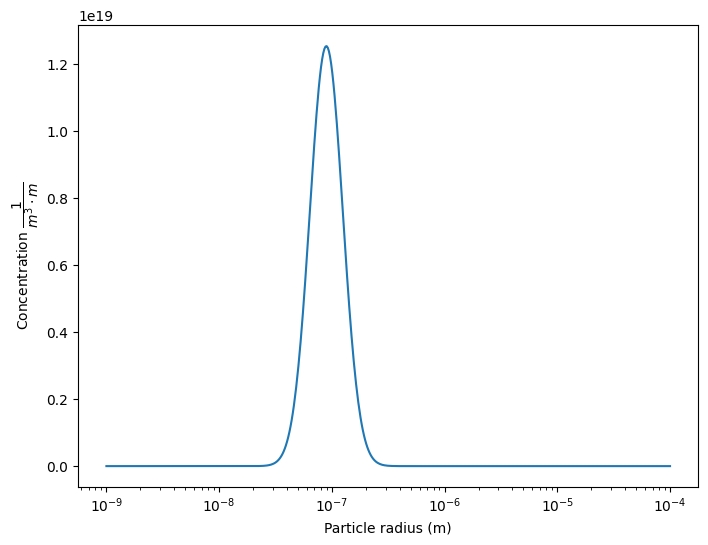

In [21]:
# Generate a lognormal particle size distribution
# This distribution is characterized by a mode (most probable size) of 100 nm,
# a geometric standard deviation of 1.4, and a total number concentration of 1e6 particles per cm^3.
concentration_lognormal_0 = lognormal_pdf_distribution(
    x_values=radius_bins,
    mode=np.array(100e-9),  # Mode of the distribution (100 nm)
    geometric_standard_deviation=np.array(1.4),  # Geometric standard deviation
    number_of_particles=np.array(
        1e6 * 1e6
    ),  # Total concentration (1e6 cm^-3 converted to m^-3)
)

# Plot the lognormal concentration distribution
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(radius_bins, concentration_lognormal_0)

# Set the x-axis to a logarithmic scale to capture the wide range of particle sizes
ax.set_xlabel("Particle radius (m)")

# Label the y-axis to show the concentration in particles per cubic meter per unit size
ax.set_ylabel(r"Concentration $\dfrac{1}{m^3 \cdot m}$")

# Use a logarithmic scale for the x-axis to better visualize the distribution across particle sizes
ax.set_xscale("log")

# Display the plot
plt.show()

## Simulating the Coagulation Process for a Lognormal Distribution

After establishing a lognormal particle size distribution, we now simulate the coagulation process over time to observe how the distribution evolves as particles collide and form larger particles.

### Simulation Setup

- **Time Step**: We use a time step of 100 seconds (`TIME_STEP = 100`). This interval determines the frequency at which particle concentrations are updated based on the calculated coagulation rates.

- **Coagulation Kernel**: The coagulation kernel is computed using the same environmental parameters (temperature, pressure, and collision efficiency) as before. The kernel remains unchanged throughout the simulation, as it depends solely on the physical properties of the particles and the surrounding environment.

### Time Step Calculations

For each time step, we perform the following calculations:

1. **Time Step 1**:
   - **Gain and Loss Rates**: Calculate the gain and loss rates for the initial concentration (`concentration_lognormal_0`) based on the coagulation kernel.
   - **Update Concentration**: Apply the net rate of change to update the particle concentration to `concentration_lognormal_1`. Any negative concentrations, which may result from numerical errors, are set to zero.

2. **Time Step 2**:
   - **Recalculate Rates**: Compute the gain and loss rates using the updated concentration (`concentration_lognormal_1`).
   - **Update Concentration**: Update the concentration to `concentration_lognormal_2`, ensuring no negative values.

3. **Time Step 3**:
   - **Recalculate Rates**: Calculate the rates again based on the most recent concentration (`concentration_lognormal_2`).
   - **Update Concentration**: Update the concentration to `concentration_lognormal_3`, correcting any negative concentrations.

### Combining Results

The concentrations at each time step are combined into a `pandas` DataFrame. This structure facilitates easy comparison of the particle size distribution changes over time, offering insights into the coagulation process.

### Optional: Saving Results

For further analysis or documentation, the concentration data can be saved to a CSV file. This step is optional but can be useful for detailed post-simulation analysis.


In [22]:
# Simulating the coagulation process over time for a lognormal distribution

# Define the time step for the simulation
TIME_STEP = 100  # seconds

# Calculate the coagulation kernel
kernel = brownian_kernel.brownian_coagulation_kernel_via_system_state(
    radius_particle=radius_bins,
    mass_particle=mass_bins,
    temperature=293.15,  # Temperature in Kelvin
    pressure=101325,  # Pressure in Pascals (1 atm)
    alpha_collision_efficiency=1.0,  # Assume perfect collision efficiency
)

# Time step 1: Calculate gain, loss, and update concentration
gain = rate.continuous_gain(radius=radius_bins, concentration=concentration_lognormal_0, kernel=kernel)
loss = rate.continuous_loss(radius=radius_bins, concentration=concentration_lognormal_0, kernel=kernel)
net = gain - loss
concentration_lognormal_1 = concentration_lognormal_0 + net * TIME_STEP
concentration_lognormal_1[concentration_lognormal_1 < 0] = (
    0  # Ensure no negative concentrations
)

# Time step 2: Recalculate rates and update concentration
gain = rate.continuous_gain(radius=radius_bins, concentration=concentration_lognormal_1, kernel=kernel)
loss = rate.continuous_loss(radius=radius_bins, concentration=concentration_lognormal_1, kernel=kernel)
net = gain - loss
concentration_lognormal_2 = concentration_lognormal_1 + net * TIME_STEP
concentration_lognormal_2[concentration_lognormal_2 < 0] = (
    0  # Ensure no negative concentrations
)

# Time step 3: Recalculate rates and update concentration
gain = rate.continuous_gain(radius=radius_bins, concentration=concentration_lognormal_2, kernel=kernel)
loss = rate.continuous_loss(radius=radius_bins, concentration=concentration_lognormal_2, kernel=kernel)
net = gain - loss
concentration_lognormal_3 = concentration_lognormal_2 + net * TIME_STEP
concentration_lognormal_3[concentration_lognormal_3 < 0] = (
    0  # Ensure no negative concentrations
)

# Combine the concentrations at each time step into a DataFrame for easy comparison
df_concentration = pd.DataFrame(
    {
        "0": concentration_lognormal_0,
        "1": concentration_lognormal_1,
        "2": concentration_lognormal_2,
        "3": concentration_lognormal_3,
    },
    index=radius_bins,
)

# Optional: Save the concentration data to a CSV file for further analysis
# df_concentration.to_csv("concentration_lognormal_sim.csv")

## Plotting the Coagulation Gain, Loss, and Net Rates for Lognormal Distribution

To visualize the dynamics of coagulation for a lognormal particle size distribution, we plot the rates of gain, loss, and net change in concentration across the range of particle sizes. This plot provides insights into how particles are interacting during the coagulation process.

### Plot Details

- **Net Rate**: The net rate of change in particle concentration is plotted as a thick gray line. This line represents the overall effect of coagulation, indicating whether the concentration in each size bin is increasing or decreasing.

- **Gain Rate**: The gain rate, plotted in dark green, shows how particles are being added to each size bin as smaller particles coagulate to form larger ones. This rate reflects the accumulation of particles in specific size bins.

- **Loss Rate**: The loss rate is plotted in red, with the values multiplied by -1 to indicate that it represents a reduction in particle concentration. This line shows how particles are being depleted from each size bin due to coagulation.

### Axes Configuration

- **X-axis**: The x-axis represents the particle radius in meters, plotted on a logarithmic scale to capture the wide range of particle sizes present in the distribution.
  
- **Y-axis**: The y-axis shows the rate of change in concentration in units of particles per cubic meter per second ($\dfrac{1}{m^{3} s^{1} \cdot m}$), providing a clear view of how rapidly particles are being gained, lost, or changing net concentration in the system.

### Legend and Interpretation

A legend is included to clearly differentiate between the net, gain, and loss lines on the plot. By analyzing these rates, we can determine the most active particle sizes in the coagulation process:

- **Positive Net Rate**: Indicates that the particle size bin is gaining particles, likely due to the aggregation of smaller particles.
- **Negative Net Rate**: Indicates that the particle size bin is losing particles, either because they are merging into larger particles or being depleted through other processes.

This plot is essential for understanding the detailed behavior of the particle size distribution during coagulation, highlighting which sizes are most affected by the process.


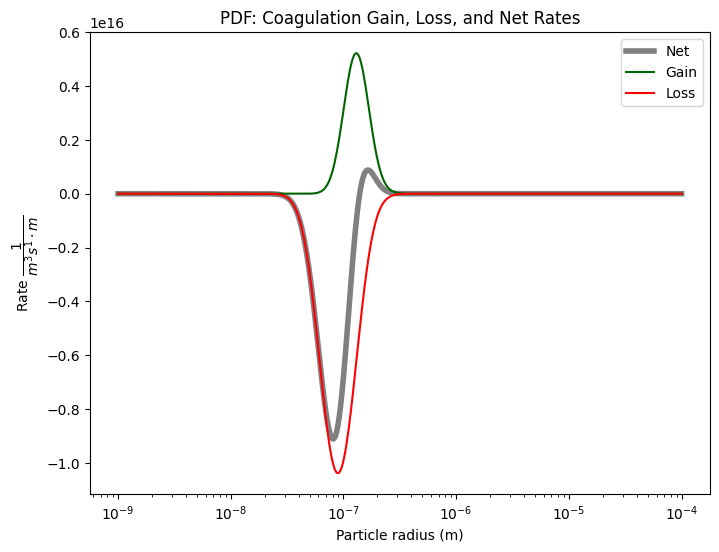

In [23]:
# Plot the coagulation gain, loss, and net rates for the lognormal distribution

# Create a figure and axis object for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the net coagulation rate
# The net rate is plotted with a thicker gray line for emphasis
ax.plot(radius_bins, net, label="Net", color="gray", linewidth=4)

# Plot the gain rate
# The gain rate is plotted in dark green
ax.plot(radius_bins, gain, label="Gain", color="darkgreen")

# Plot the loss rate
# The loss rate is plotted in red, and multiplied by -1 for plotting to indicate that it's a removal process
ax.plot(radius_bins, -1 * loss, label="Loss", color="red")

# Set the x-axis label to indicate the particle radius in meters
ax.set_xlabel("Particle radius (m)")

# Set the y-axis label to indicate the rate of change in concentration, with appropriate units
ax.set_ylabel(r"Rate $\dfrac{1}{m^{3} s^{1} \cdot m}$")

# Use a logarithmic scale for the x-axis to account for the wide range of particle sizes
ax.set_xscale("log")

# title
ax.set_title("PDF: Coagulation Gain, Loss, and Net Rates")

# Add a legend to identify the gain, loss, and net lines
plt.legend()    

# Display the plot
plt.show()

## Plotting the Evolution of Concentration for Lognormal Distribution

After simulating the coagulation process over several time steps, it is important to visualize how the particle concentration evolves. This plot shows the concentration distribution at different time steps, allowing us to observe the changes in the lognormal distribution as coagulation progresses.


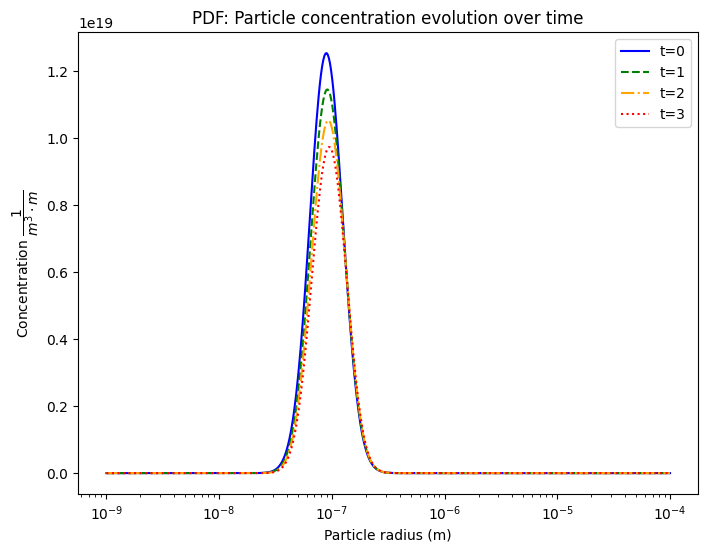

In [24]:
# Plot the evolution of particle concentration over time for the lognormal distribution

# Create a figure and axis object for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the concentration distribution at each time step
ax.plot(
    radius_bins,
    concentration_lognormal_0,
    label="t=0",
    linestyle="-",
    color="blue",
)
ax.plot(
    radius_bins,
    concentration_lognormal_1,
    label="t=1",
    linestyle="--",
    color="green",
)
ax.plot(
    radius_bins,
    concentration_lognormal_2,
    label="t=2",
    linestyle="-.",
    color="orange",
)
ax.plot(
    radius_bins,
    concentration_lognormal_3,
    label="t=3",
    linestyle=":",
    color="red",
)

# Set the x-axis label to indicate the particle radius in meters
ax.set_xlabel("Particle radius (m)")

# Set the y-axis label to indicate the concentration in particles per cubic meter
ax.set_ylabel(r"Concentration $\dfrac{1}{m^3 \cdot m}$")

# Set the title of the plot to describe the concentration evolution over time
ax.set_title("PDF: Particle concentration evolution over time")

# Use a logarithmic scale for both the x-axis and y-axis
# This is essential for visualizing the wide range of particle sizes and concentration changes
ax.set_xscale("log")
# ax.set_yscale("log")

# Add a legend to differentiate between the time steps
plt.legend()

# Display the plot
plt.show()

## Calculating and Visualizing Total Particle Concentration Over Time

In this section, we calculate the total number of particles at each time step by integrating the particle concentration across the size distribution. This provides a clear view of how the total particle concentration evolves as coagulation progresses.

### Integration of Particle Concentration

To determine the total number of particles at each time step, we integrate the concentration across all particle sizes using the trapezoidal rule. This integration gives us the total particle concentration (in particles per cubic meter) at each specific time step.

### Plotting Total Concentration Over Time

We then plot the total particle concentration for each time step to visualize how the overall concentration decreases as particles coagulate into larger sizes. The x-axis represents the time steps, while the y-axis shows the total particle concentration in particles per cubic meter. Markers are used to highlight the concentration at each time step, connected by a solid line to indicate the trend over time.

This plot provides a straightforward representation of the coagulation process's impact on the total number of particles, illustrating the decrease in concentration as particles merge and grow.

### Note:

You can compare the results obtained from the PDF representation with those from the PMF representation in the previous notebook to observe how similar the results are despite the different representations. They are not exactly equal.

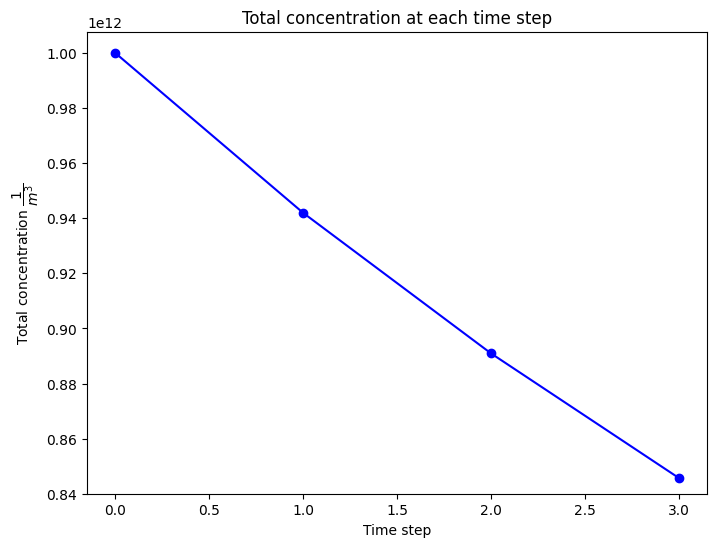

In [25]:
# Integrate the concentration to calculate the total number of particles at each time step
total_concentration_lognormal_0 = trapezoid(
    concentration_lognormal_0, x=radius_bins
)
total_concentration_lognormal_1 = trapezoid(
    concentration_lognormal_1, x=radius_bins
)
total_concentration_lognormal_2 = trapezoid(
    concentration_lognormal_2, x=radius_bins
)
total_concentration_lognormal_3 = trapezoid(
    concentration_lognormal_3, x=radius_bins
)

# Plot the total concentration at each time step for the lognormal distribution
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the total concentration at each time step
ax.plot(
    [
        total_concentration_lognormal_0,
        total_concentration_lognormal_1,
        total_concentration_lognormal_2,
        total_concentration_lognormal_3,
    ],
    label="Total concentration",
    marker="o",  # Add markers to indicate each time step
    linestyle="-",  # Use a solid line to connect the markers
    color="blue",  # Set the line color to blue
)

# Set the x-axis label to indicate the time step
ax.set_xlabel("Time step")

# Set the y-axis label to indicate the total concentration in particles per cubic meter
ax.set_ylabel("Total concentration $\dfrac{1}{m^3}$")
ax.set_ylim(bottom=0.84e12)

# Set the title of the plot to describe the total concentration evolution over time
ax.set_title("Total concentration at each time step")

# Display the plot
plt.show()

### Summary

In this notebook, we explored the process of particle coagulation in aerosols, with a particular focus on probability density function (PDF) representations of lognormal particle size distributions. 

We began by defining a lognormal distribution, which is commonly used to represent aerosol particle sizes due to its ability to model the skewed distributions observed in real-world scenarios. We then calculated the Brownian coagulation kernel, a crucial element that quantifies the rate at which particles of different sizes collide and coagulate due to Brownian motion. 

Through a series of simulations, we observed how the particle size distribution evolves over time as coagulation occurs. By applying the coagulation kernel to the initial distribution, we calculated the gain and loss rates for particles and updated the particle concentrations at each time step. This iterative process illustrated the gradual decrease in total particle concentration as smaller particles combined to form larger ones.

Finally, we integrated the particle concentrations across the size distribution at each time step to determine the total number of particles present. This allowed us to visualize the overall reduction in particle concentration over time, providing a clear demonstration of the impact of coagulation on aerosol dynamics.

This notebook not only highlights the fundamental principles of aerosol coagulation but also provides a practical framework for modeling and analyzing these processes using PDF representations. The methodologies and tools used here, such as the integration of concentration data and the use of a coagulation kernel, are essential for understanding the behavior of aerosols in various environmental and industrial contexts.